# Retrosynthetically Decompose a Molecule In a Tree Structure Using Recap in RDKit--Update to Annotate Diagram Programmatically

This is an update of a [Recap retrosynthetic tree blog post](https://bertiewooster.github.io/2022/11/11/RDKit-Recap-decomposition-tree.html) to programmatically annotate the diagram. Previously, I exported the drawing from the RDKit and manually annotated the it with another program. After reading [Greg Landrum's RKDit blog post Drawing on drawings](https://greglandrum.github.io/rdkit-blog/posts/2025-03-07-drawing-on-drawings.html), I wanted to automate annotating the tree.

[Retrosynthetic analysis](https://en.wikipedia.org/wiki/Retrosynthetic_analysis) involves decomposing a target molecule into a set of fragments that could be combined to make the parent molecule using common reactions. The [Recap algorithm](https://www.semanticscholar.org/paper/RECAP-%E2%80%94-Retrosynthetic-Combinatorial-Analysis-A-New-Lewell-Judd/fbfb10d1f63aa803f6d47df6587aa0e41109f5ee) by X. Lewell, D. Judd, S. Watson, and M. Hann accomplishes that. [Recap is implemented in the RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#recap-implementation) cheminformatics Python package.

*[Download this notebook from GitHub by right-clicking and choosing Save Link As...](https://raw.githubusercontent.com/bertiewooster/bertiewooster.github.io/main/_notebooks/2022-11-11-RDKit-Recap-decomposition-tree.ipynb)*

RDKit helpfully provides a `RecapHierarchyNode` structure of nodes, where the keys are SMILES strings corresponding to the fragment, and the values are nodes containing child fragments. However, it is not easy to visualize the results, because the results are SMILES strings and the hierarchy is not shown visually.

This utility function `molecule_recap_tree` allows you to visualize both the fragments and their hierarchy. Here is an example, of [6-(Hydroxymethoxy)pyridin-2-yl]oxymethanol, annotated to explain the hierarchy:

![annotated_hierarchy_tree](../images/tree_marked_up_automated.svg)

As compared to the same molecule using the `RecapDecompose` function directly, showing only the immediate children:

In [1]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import Draw, Recap
from rdkit import Geometry

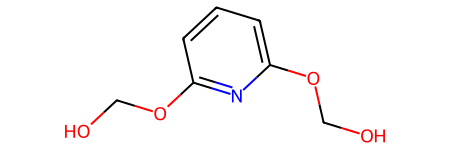

In [2]:
parent = "n1c(OCO)cccc1OCO"
molecule = Chem.MolFromSmiles(parent)
hierarch = Recap.RecapDecompose(molecule)
ks = hierarch.children.keys()
sorted(ks)
molecule

In [3]:
def concat_grids_horizontally(
    grid1: list[list[str]], grid2: list[list[str]]
) -> list[list[str]]:
    """Concatenate two nested lists horizontally, for example
    inputs [['a'],['b'],['c']] and [['d'], ['e'], ['f']]
    produce [['a', 'd'], ['b', 'e'], ['c', 'f']]

    :returns: The combined grid, a two-deep nested list of strings
    :param grid1: The first grid, a two-deep nested list of strings
    :param grid2: The second grid, a two-deep nested list of strings
    """
    if grid1 == [[]]:
        combined = grid2
    elif grid2 == [[]]:
        combined = grid1
    else:
        combined = []
        for row_counter in range(len(grid1)):
            combined += [grid1[row_counter] + grid2[row_counter]]
    return combined


class NonBinTree:
    """
    Nonbinary tree class
    Note that this class is not designed to sort nodes as they are added to the tree;
    the assumption is that they should be ordered in the order added
    Adapted from https://stackoverflow.com/questions/60579330/non-binary-tree-data-structure-in-python#60579464
    """

    def __init__(self, val: str):
        """Create a NonBinTree instance"""
        self.val = val
        self.nodes = []

    def add_node(self, val: str):
        """Add a node to the tree and return the new node"""
        self.nodes.append(NonBinTree(val))
        return self.nodes[-1]

    def __repr__(self) -> str:
        """Print out the tree as a nested list"""
        return f"NonBinTree({self.val}): {self.nodes}"

    def get_ncols(self) -> int:
        """Get the number of columns in the tree"""
        self.ncols = 0
        if len(self.nodes) > 0:
            # If there are nodes under this one, call get_ncols on them recursively
            for node in self.nodes:
                self.ncols += node.get_ncols()
        else:
            # If there are no nodes under this one, add 1 for this node
            self.ncols += 1
        return self.ncols

    def get_max_depth(self) -> int:
        """Get the maximum depth of the tree"""
        max_depth = 0
        if len(self.nodes) > 0:
            for node in self.nodes:
                this_depth = node.get_max_depth()
                max_depth = max(this_depth + 1, max_depth)
        else:
            max_depth = max(1, max_depth)
        self.max_depth = max_depth
        return self.max_depth

    def get_grid(self) -> list[list[str]]:
        """
        Get a two-dimensional grid where
        each row is a level in the fragment hierarchy, and
        the columns serve to arrange the fragments horizontally
        """
        # Call methods to calculate self.ncols and self.max_depth
        self.get_ncols()
        self.get_max_depth()

        # Create top row: Node value, then the rest of columns are blank (empty strings)
        grid = [[self.val] + [""] * (self.ncols - 1)]

        n_nodes = len(self.nodes)

        if n_nodes > 0:
            nodes_grid = [[]]

            # Iterate through the child nodes
            for node_counter, node in enumerate(self.nodes):
                # Recursively call this function to get the grid for children
                node_grid = node.get_grid()

                # Add spacer rows if needed
                node_grid_rows = len(node_grid)
                rows_padding = self.max_depth - node_grid_rows - 1
                for padding in range(rows_padding):
                    node_grid += [[""] * len(node_grid[0])]

                nodes_grid = concat_grids_horizontally(nodes_grid, node_grid)

            grid += nodes_grid

        return grid

In [4]:
def get_children(
    base_node: Chem.Recap.RecapHierarchyNode, root: NonBinTree = None
) -> NonBinTree:
    """
    Convert an RDKit RecapHierarchyNode into a NonBinTree by
    traversing the RecapHierarchyNode, getting all its children recursively, and adding them to a NonBinTree

    :returns: NoBinTree containing the Recap hierarchy
    :param base_node: The RDKit RecapHierarchyNode
    :param root: The NoBinTree containing only the root node
    """
    for smiles, node in base_node.children.items():
        added_tree_node = root.add_node(smiles)
        children = node.children.keys()
        # Sort the children nodes to get consistent ordering
        children = sorted(children)
        if len(children) > 0:
            get_children(node, added_tree_node)
    return root

Here comes the new part, annotating the tree. It has two parts:

1. The `Increasing fragmentation` text and arrow on the left edge from the top to the bottom of the tree. This is simple to draw because it applies to the tree as a whole, so we just need to calculate where to draw the text and arrow once.
2. Draw an arrow from each parent to child (fragment). This requires more logic to detect each parent-child pair.
    1. RDKit's DrawArrow specifies the arrowhead size as a fraction of the line's length. I want all the arrowheads to be the same size, so I set the fraction to be inversely proportional to the line length using the `arrow_length` logic.
    2. I decided to drop the "Fragments" labels under the arrows because the "Increasing fragmentation" label explains what the vertical axis means.

To draw on the drawing, we use DrawMolecules rather than [`MolsMatrixToGridImage`](https://greglandrum.github.io/rdkit-blog/posts/2023-10-25-molsmatrixtogridimage.html) or [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html#rdkit.Chem.Draw.MolsToGridImage) as in the [original blog post](https://bertiewooster.github.io/2022/11/11/RDKit-Recap-decomposition-tree.html).

In [5]:
def annotate_recap_tree(
    molsMatrix: list[list[Chem.Mol]],
    fragment_grid: list[list[str]],
    recap_plot: list[str],
):
    """
    Annotate the Recap tree with arrows and labels

    :returns: RDKit grid image
    :rtype: RDKit grid image
    :param molsMatrix: The matrix of RDKit molecules
    :param fragment_grid: The matrix of fragment SMILES strings
    :param recap_plot: The list of Recap SMILES strings
    """
    nRows = len(molsMatrix)
    nCols = len(molsMatrix[-1])
    panelx = 250
    panely = 250
    width = panelx * nCols
    height = panely * nRows
    d2d = Draw.MolDraw2DSVG(width, height, panelx, panely)
    dopts = d2d.drawOptions()
    dopts.legendFontSize = 20

    recap_plot_mols = [Chem.MolFromSmiles(sml) for sml in recap_plot]

    # Draw the molecule and fragments
    d2d.DrawMolecules(
        recap_plot_mols,
        legends=recap_plot,
    )

    d2d.SetLineWidth(4)
    font_size = 20
    d2d.SetFontSize(font_size)

    # Use gray arrows
    arrowColor = (0.4, 0.4, 0.4)

    # Arrow for "Increasing Fragmentation"
    p1 = Geometry.Point2D(panelx * 3 / 4, panely / 4)
    p2 = Geometry.Point2D(panelx * 3 / 4, height - 10)
    d2d.DrawArrow(p1, p2, color=arrowColor, rawCoords=True, asPolygon=False, frac=0.01)

    # Text "Increasing Fragmentation"
    midp = Geometry.Point2D()
    midp.x = panelx * 1 / 4
    midp.y = height / 2
    d2d.DrawString("Increasing", midp, rawCoords=True)
    midp.y += font_size
    d2d.DrawString("fragmentation", midp, rawCoords=True)

    # Constant used to make arrowhead size constant
    # regardless of the length of the arrow
    arrow_length = 10

    # Iterate through fragment grid to draw the Fragments and their arrows
    for row_index, row in enumerate(fragment_grid[:-1]):
        # Find the non-empty entries in this row
        this_row_filled_indexes = set()
        for column_index, entry in enumerate(row):
            if entry:
                this_row_filled_indexes.add(column_index)
        # Add a ghost entry for beyond the last column
        this_row_filled_indexes.add(len(row))

        # Iterate through the columns in this row
        #   and draw an arrow for each fragment that has children
        for col_index, sml in enumerate(row):
            if not col_index:
                # Skip the first column, which is the whole-chart label "Increasing Fragmentation"
                continue

            # The next sibling index is the index of the next fragment in the same row
            #   that is not blank (empty string)
            next_sibling_index = min(
                index for index in this_row_filled_indexes if index > col_index
            )

            # If no molecule at this row_index, col_index, skip drawing an arrow
            if not sml:
                continue

            # If no molecule directly below this row_index, col_index, skip drawing an arrow
            if not fragment_grid[row_index + 1][col_index]:
                continue

            # Set the starting point of all arrows for this parent
            #   to be below the center of the current fragment
            p1 = Geometry.Point2D(
                panelx * (col_index + 1 / 2), row_index * panely + panely * 1
            )
            for child_col_index in range(col_index, next_sibling_index):
                # If no molecule directly below this row_index, child_col_index, skip drawing an arrow
                if not fragment_grid[row_index + 1][child_col_index]:
                    continue
                # Set the end point of this arrow to be above the center of the child (fragment)
                p2 = Geometry.Point2D(
                    p1.x + panelx * (child_col_index - col_index),
                    row_index * panely + panely * 1.25,
                )

                # Set the arrowhead size to be constant
                # regardless of the length of the arrow
                length = ((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2) ** 0.5
                try:
                    frac = arrow_length / length
                except ZeroDivisionError:
                    frac = 0

                d2d.DrawArrow(
                    p1, p2, color=arrowColor, rawCoords=True, asPolygon=False, frac=frac
                )
    d2d.FinishDrawing()
    svg = d2d.GetDrawingText()
    return svg

In [6]:
def molecule_recap_tree(smiles: str, name: str = "", verbose=False) -> SVG:
    """
    Draw a molecular fragmentation tree using the Recap algorithm given in
    https://www.semanticscholar.org/paper/RECAP-%E2%80%94-Retrosynthetic-Combinatorial-Analysis-A-New-Lewell-Judd/fbfb10d1f63aa803f6d47df6587aa0e41109f5ee

    :returns: RDKit grid image, and (if verbose=True) RDKit molecule of parent molecule, Recap hierarchy, nonbinary tree hierarchy, and fragment grid
    :rtype: RDKit grid image, and (if verbose=True) rdkit.Chem.rdchem.Mol, rdkit.Chem.Recap.RecapHierarchyNode, NonBinTree, list[list[str]]
    :param smiles: The SMILES string of the molecule to be fragmented
    :param name: The name of the parent molecule; if not supplied, it will be labled with its SMILES string
    :param verbose: Whether to return verbose output; default is False so calling this function will present a grid image automatically
    """
    molecule = Chem.MolFromSmiles(smiles)
    RecapHierarchy = Recap.RecapDecompose(molecule)
    root = NonBinTree(RecapHierarchy.smiles)
    molecule_nonbinary_tree = get_children(RecapHierarchy, root)
    fragment_grid = molecule_nonbinary_tree.get_grid()
    # Add a blank element at the beginning of each row to make room for the left legend
    for row in fragment_grid:
        row.insert(0, "")
    recap_plot = [item for sublist in fragment_grid for item in sublist]
    recap_labels = [item for sublist in fragment_grid for item in sublist]
    if name:
        recap_labels[0] = name

    molsMatrix = [
        [Chem.MolFromSmiles(smile) for smile in sublist] for sublist in fragment_grid
    ]

    drawing = annotate_recap_tree(molsMatrix, fragment_grid, recap_plot)

    if verbose:
        return (
            drawing,
            molecule,
            RecapHierarchy,
            molecule_nonbinary_tree,
            fragment_grid,
            recap_plot,
            molsMatrix,
        )
    else:
        return drawing

Here is the output annotated with RDKit:

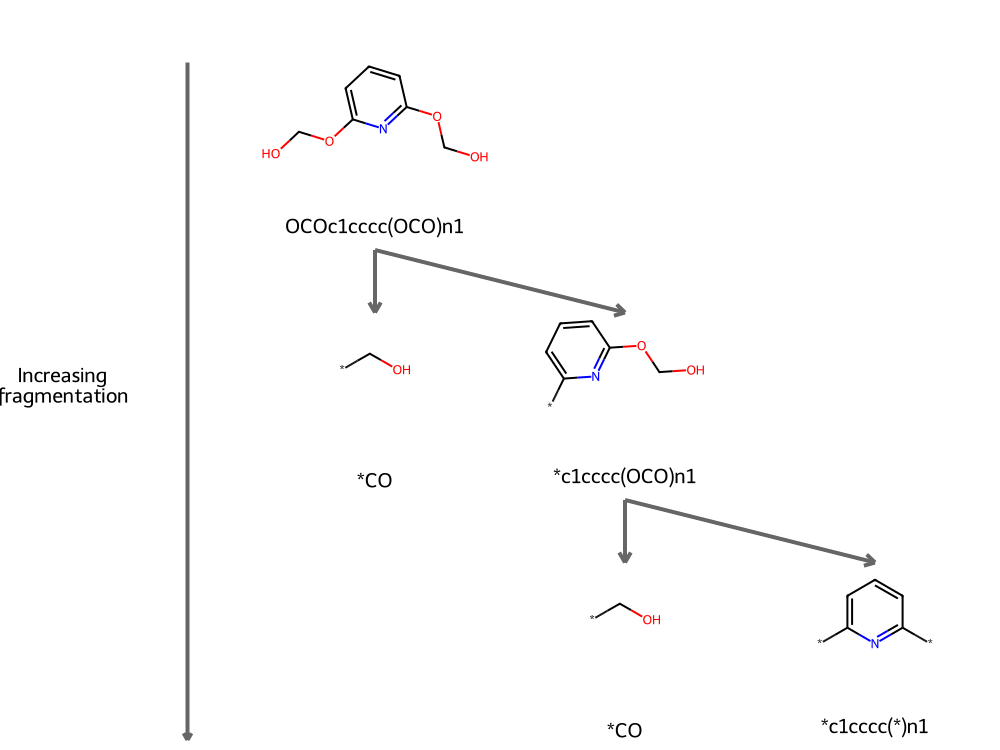

In [7]:
drawing = molecule_recap_tree(parent, "Parent molecule")
SVG(drawing)

Stars ("dummy atoms") show points where the molecule was fragmented.

The key RDKit commands that `molecule_recap_tree` uses are:
- [`RecapDecompose`](https://www.rdkit.org/docs/GettingStartedInPython.html#recap-implementation) to decompose the parent molecule into successive fragments
- [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html#rdkit.Chem.Draw.MolsToGridImage) to draw the fragment hierarchy in a grid, and label the fragments with their SMILES strings

## Get Additional Data
If you want `molecule_recap_tree` to return not just the grid image, but also the parent molecule, the RDKit Recap hiearchy node, the non-binary tree hierarchy, and grid of fragment hierarchy, set `verbose=True`:

In [8]:
(
    drawing,
    molecule,
    RecapHierarchy,
    molecule_nonbinary_tree,
    fragment_grid,
    recap_plot,
    molsMatrix,
) = molecule_recap_tree(parent, "Parent molecule", verbose=True)

You then must explicitly call the hierarchy image to draw it:

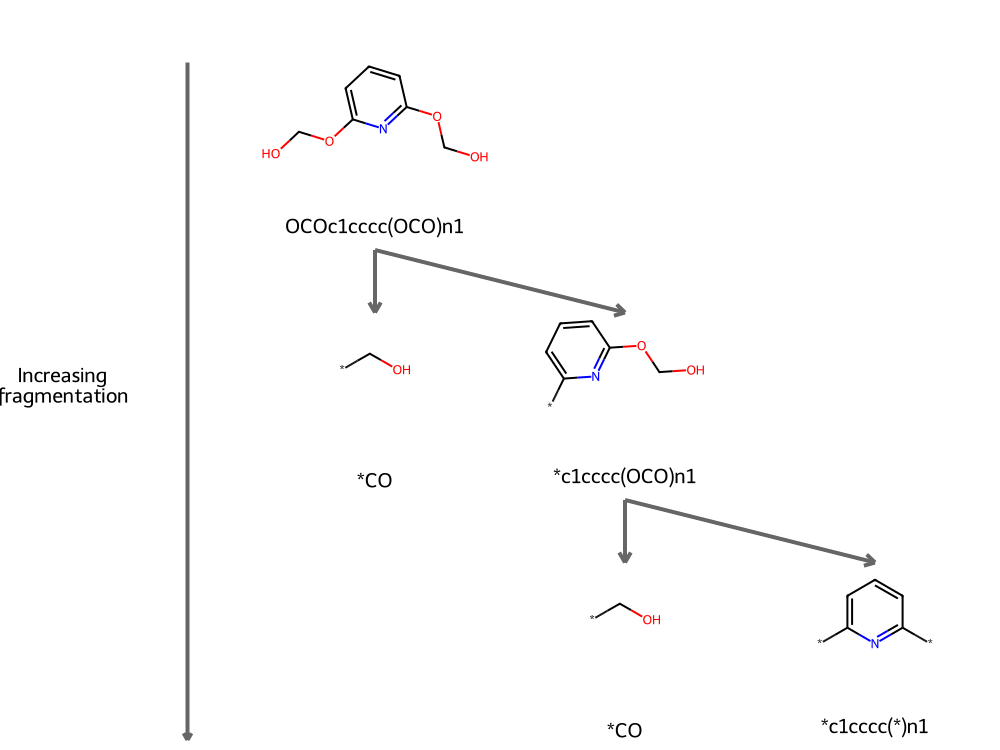

In [9]:
SVG(drawing)

`molecule` is the RDKit parent molecule:

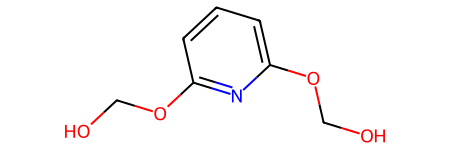

In [10]:
molecule

`RecapHierarchy` is the RDKit Recap hierarchy, which returns the top-level node, which you could traverse to obtain the hierarchy:

In [11]:
RecapHierarchy

`molecule_nonbinary_tree` is the NonBinTree hierarchy, which contains the same hierarchy as the `RecapHierarchy`, and gives all the nodes directly:

In [12]:
molecule_nonbinary_tree

NonBinTree(OCOc1cccc(OCO)n1): [NonBinTree(*CO): [], NonBinTree(*c1cccc(OCO)n1): [NonBinTree(*CO): [], NonBinTree(*c1cccc(*)n1): []]]

`fragment_grid` is the two-dimensional fragment grid, where each row is a level in the fragment hierarchy, and the columns serve to arrange the fragments horizontally:

In [13]:
fragment_grid

[['', 'OCOc1cccc(OCO)n1', '', ''],
 ['', '*CO', '*c1cccc(OCO)n1', ''],
 ['', '', '*CO', '*c1cccc(*)n1']]

Or, more nicely formatted into columns and with empty strings not shown:

In [14]:
# Get the longest string (cell) in the grid
max_length = max(
    len(item) for sublist in fragment_grid for item in sublist if item != ""
)

for row in fragment_grid:
    f_str = ""
    for col in row[1:]:
        # Make each string the same length, namely the max length
        if col == "":
            f_str += f"{col:<{max_length}} "
        else:
            # Center the string in a field of max_length
            f_str += f"{col:<{max_length}} "
    print(f"{f_str}")

OCOc1cccc(OCO)n1                                   
*CO              *c1cccc(OCO)n1                    
                 *CO              *c1cccc(*)n1     


Here's an example of a larger molecule with more fragments.

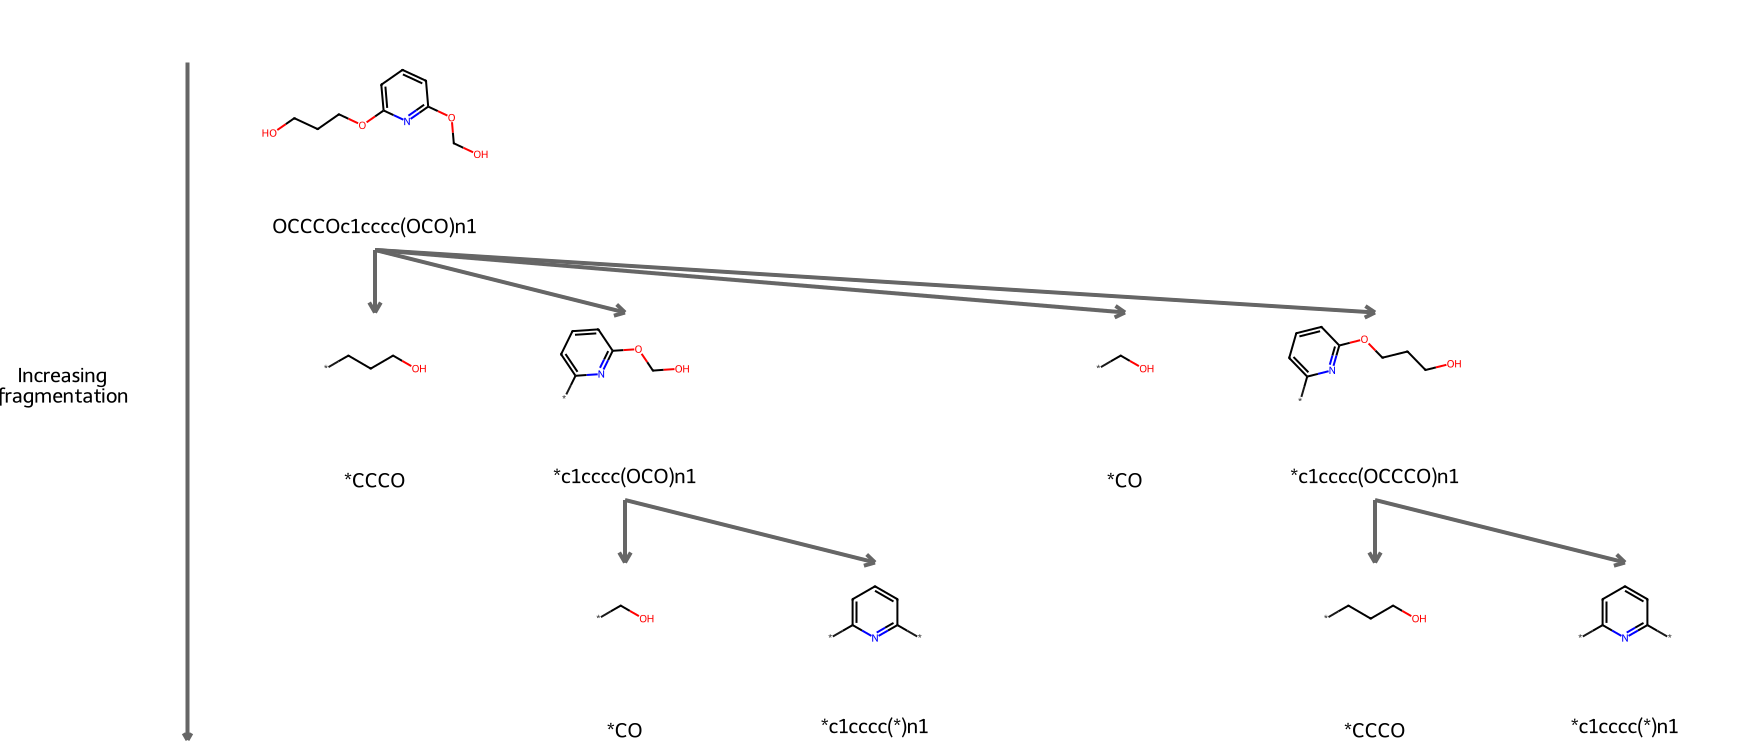

In [15]:
parent = "n1c(OCCCO)cccc1OCO"
drawing = molecule_recap_tree(parent, "Parent molecule")
SVG(drawing)

## Note About Hierarchies
Another approach I could have taken was to extend the class `rdkit.Chem.Recap.RecapHierarchyNode`, rather than use the `NonBinaryTree` class. Using the `NonBinaryTree` class allows for different kinds of hierarchies to be depicted as a grid, as I demonstrate in other posts [Visualizing Nonbinary Trees: Classification of Chemical Isomers]({% post_url 2022-12-18-Visualizing-Nonbinary-Trees-Classification-of-Chemical-Isomers %}) and [Draw a Mass Spectrometry Fragmentation Tree Using RDKit]({% post_url 2023-01-02-Mass-Spectrometry-Fragmentation-Tree %}).